## Interactive model tester
This allows interactive use of a saved Estimator model against systems configured for the **formal-test-set**.

In [1]:
from pathlib import Path
import json
import re

import numpy as np
import astropy.units as u

%matplotlib widget 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *

from ebop_maven.libs import lightcurve, deb_example, jktebop
from ebop_maven import datasets
from ebop_maven.estimator import Estimator

#### Create our Estimator

In [2]:
model_path = Path.cwd() / "drop" / "cnn_ext_model.keras"
estimator = Estimator(model=model_path)

Estimator loading model file '/home/steveo/projects/main/ebop_maven/drop/cnn_ext_model.keras'...
Loaded 'CNN-Ext-Estimator-New' last modified at 2024-04-15T20:22:07.086963.
	Inputs: [(None, 1024, 1), (None, 2, 1)]
	Outputs: (None, 6)


#### Target selection

In [3]:
targets_config_file = Path.cwd() / "config" / "formal-test-dataset.json"
with open(targets_config_file, mode="r", encoding="utf8") as cf:
    targets_cfg = json.load(cf)

target_selection = Dropdown(options=[t for t in targets_cfg], value="CW Eri")
display(target_selection)

Dropdown(index=13, options=('V436 Per', 'V539 Ara', 'psi Cen', 'V402 Lac', 'V1229 Tau', 'V889 Aql', 'WW Aur', …

#### Ingest the target assets

In [4]:
target = target_selection.get_interact_value()
target_cfg = targets_cfg[target]
sectors = [int(s) for s in target_cfg["sectors"].keys() if s.isdigit()]

# This will download and cache the timeseries fits files
fits_dir = Path.cwd() / "cache" / re.sub(r'[^\w\d-]', '_', target.lower())
lightcurve.find_lightcurves(target, fits_dir, sectors,
                            mission = target_cfg.get("mission", "TESS"),
                            author=target_cfg.get("author", "SPOC"),
                            exptime=target_cfg.get("exptime", None))

Searching for lightcurves based on; target=CW Eri, sectors=[31], mission=TESS, author=SPOC and exptime=None
Looking for previously downloaded fits within /home/steveo/projects/main/ebop_maven/cache/cw_eri
Found 2 existing fits matching mission and author criteria
Found the required 1 fits also meeting the sectors & exptime criteria. Will load the requested lightcurves from these.


LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 98853987" SECTOR=31 AUTHOR=SPOC FLUX_ORIGIN=sap_flux>

In [5]:
sectors_data = []          # Will hold the LC data to be fitted with JKTEBOP

for sector in sectors:
    sector_cfg = datasets.sector_config_from_target(sector, target_cfg)

    # These are mandatory, so error if missing
    labels = sector_cfg["labels"]
    period = sector_cfg["period"] * u.d
    pe = sector_cfg["primary_epoch"]

    # The basic light-curve data read, rectified & extended with delta_mag and delta_mag_err cols
    lc = datasets.prepare_lc_for_target_sector(target, sector, sector_cfg, fits_dir, verbose=True)

    # Get the phase folded and binned mags feature
    # TODO: need to update the Estimator to publish both of these
    pe = lightcurve.to_lc_time(pe, lc)
    print(f"Creating phase normalized, folded lightcurves about", f"{pe.format} {pe} & {period}.")
    mags_bins = estimator.mags_feature_bins
    wrap_phase = deb_example.stored_mags_features[deb_example.pub_mags_key][1]
    fold_lc = lc.fold(period, pe, wrap_phase=u.Quantity(wrap_phase), normalize_phase=True)
    phases, mags = lightcurve.get_reduced_folded_lc(flc=fold_lc, num_bins=mags_bins, phase_pivot=wrap_phase)
    
    # omega & ecc are not used as labels but we may need them for phiS
    ecosw, esinw = labels["ecosw"], labels["esinw"]
    omega = sector_cfg.get("omega", None) or np.rad2deg(np.arctan(np.divide(esinw, ecosw))) if ecosw else 0
    ecc = sector_cfg.get("ecc", None) or np.divide(ecosw, np.cos(np.deg2rad(omega))) if ecosw else 0

    # This is everything we need for this sector going forward
    sectors_data += [{
        "sector": sector,
        "config": sector_cfg,
        "labels": labels,
        "pe": pe,
        "period": period,

        # For plots and JKTEBOP dat file
        "lc": lc,
        "fold_lc": fold_lc,
        "phases": phases,

        # For ML parameter estimatation
        "mags": mags,
        "phiS": lightcurve.expected_secondary_phase(labels["ecosw"], ecc),
        "dS_over_dP": lightcurve.expected_ratio_of_eclipse_duration(labels["esinw"])
    }]

Searching for lightcurves based on; target=CW Eri, sectors=[31], mission=TESS, author=SPOC and exptime=short
Looking for previously downloaded fits within /home/steveo/projects/main/ebop_maven/cache/cw_eri
Found 2 existing fits matching mission and author criteria
Found the required 1 fits also meeting the sectors & exptime criteria. Will load the requested lightcurves from these.
NaN/negative flux masks match 0 row(s).
Time range mask(s) matched a further 0 row(s).
	Generated polynomial; y = poly(x, c0 = -12.432101589922793, c1 = 7.209015883953336e-05, c2 = -9.30984102858426e-06) (sigma(fit_ydata)=5.904455e-04 mag)
Creating phase normalized, folded lightcurves about btjd 2163.057026533 & 2.728420258 d.


#### Plot the sector light-curves alongside the phase folded model

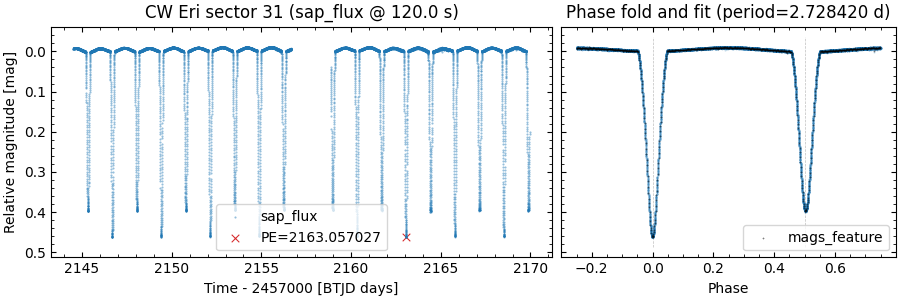

In [6]:
rows = len(sectors)
fig = plt.figure(figsize=(9, 3*rows), constrained_layout=True)
gs = GridSpec(figure=fig, ncols=2, nrows=rows, width_ratios=(3, 2))

target_label = target_cfg.get("label", target)
for ix, sector_data in enumerate(sectors_data):
    sector_cfg = sector_data["config"]
    
    flux = sector_cfg.get("flux_column", "sap_flux") # TODO: read from LC
    exptime = sector_data["lc"].meta["FRAMETIM"] * sector_data["lc"].meta["NUM_FRM"] * u.s
    
    ax_lc = fig.add_subplot(gs[ix, 0])
    sector_data["lc"].scatter(column="delta_mag", ax=ax_lc, s=1, alpha=.5, label=flux)
    ax_lc.set_ylabel("Relative magnitude [mag]")
    ax_lc.set_xlabel(None if ix < rows-1 else ax_lc.get_xlabel())
    ax_lc.minorticks_on()
    ax_lc.tick_params(axis="both", which="both", direction="in", bottom=True, top=True, left=True, right=True)
    ax_lc.set_title(f"{target_label} sector {sector} ({flux} @ {exptime})")
    ax_lc.invert_yaxis()
    ax_lc.scatter([pe.value], [sector_data["lc"]["delta_mag"].max().value], zorder=-10,
                  marker="x", s=30., lw=.75, c="tab:red", label=f"PE={pe.value:.6f}")
    ax_lc.legend()

    ax_fold = fig.add_subplot(gs[ix, 1], sharey=ax_lc)
    sector_data["fold_lc"].scatter(column="delta_mag", ax=ax_fold, s=1, alpha=.25, label=None)
    ax_fold.scatter(sector_data["phases"], sector_data["mags"], c="k", alpha=.5, marker="+", s=3, lw=.5, label="mags_feature")
    ax_fold.set_ylabel(None)
    ax_fold.set_xlabel(None if ix<rows-1 else ax_fold.get_xlabel())
    ymin, ymax = ax_fold.get_ylim()
    ax_fold.vlines([0.0, 0.5], ymin, ymax, linestyles="--", color="k", lw=.5, alpha=.25)
    ax_fold.minorticks_on()
    ax_fold.set_title(f"Phase fold and fit (period={period:.6f})")
    ax_fold.tick_params(axis="both", which="both", direction="in", bottom=True, top=True, left=True, right=True, labelleft=False)
    ax_fold.legend()

#### Estimate the JKTEBOP fitting parameters

In [7]:
# An iterations value over 1 triggers the MC Dropout algorithm giving us nominal and 1-sigma values.
# The model predicts scaled values (e.g. predicting inc*0.01) which the Estimator usually ondoes,
# but here we would like the scaled values to report on model performance as model.evaluate() would.
unscale = True
instance_features = [{ f: sd[f] for f in ["mags", "phiS", "dS_over_dP"] } for sd in sectors_data]
predictions = estimator.predict(instance_features, iterations=1000, unscale=unscale)

# Copy these into sector data
for (sd, pred) in zip(sectors_data, predictions):
    sd["predictions"] = pred

# Produce some statistics on the quality of the underlying model's predictions.
label_names = [*estimator.label_names_and_scales.keys()]
scales = [*estimator.label_names_and_scales.values()]
labels = np.multiply([[sd["labels"][l] for l in label_names] for sd in sectors_data], 1 if unscale else scales)
pred_noms = np.array([[p[l] for l in label_names] for p in predictions])
pred_errs = np.array([[p[f"{l}_sigma"] for l in label_names] for p in predictions])
ocs = np.subtract(pred_noms, labels)
mae, mse = np.mean(np.abs(ocs)), np.mean(np.power(ocs, 2))

# Plot a table
cols = len(label_names)
print(f"Estimated {'un' if unscale else ''}scaled JKTEBOP input parameters for target {target}\n")
print("           |", *[f"{n:>10s}" for n in label_names + ["MAE", "MSE"]])
for sector, snoms, slabels, socs in zip(sectors, pred_noms, labels, ocs):
    socs = np.concatenate([socs, [np.mean(np.abs(socs)), np.mean(np.power(socs, 2))]])
    print("-"*100)
    for heading, vals in zip([f"S{sector:03d} Pred", "Label", "O-C"], [snoms, slabels, socs]):
        print(f"{heading:>10s} |", *[f"{v:10.6f}" for v in vals])
print("="*100)
print(f"{'MAE':>10s} |", *[f"{v:10.6f}" for v in np.mean(np.abs(ocs), axis=0)], f"{mae:10.6f}")
print(f"{'MSE':>10s} |", *[f"{v:10.6f}" for v in np.mean(np.power(ocs, 2), axis=0)], " "*10, f"{mse:10.6f}")

Estimated unscaled JKTEBOP input parameters for target CW Eri

           | rA_plus_rB          k          J      ecosw      esinw        inc        MAE        MSE
----------------------------------------------------------------------------------------------------
 S031 Pred |   0.354669   0.987222   0.938877   0.005472  -0.004468  84.930305
     Label |   0.306620   0.703700   0.926200   0.005020  -0.012100  86.381000
       O-C |   0.048049   0.283522   0.012677   0.000452   0.007632  -1.450695   0.300504   0.364571
       MAE |   0.048049   0.283522   0.012677   0.000452   0.007632   1.450695   0.300504
       MSE |   0.002309   0.080385   0.000161   0.000000   0.000058   2.104515              0.364571


#### Generate the JKTEBOP fitting files

In [8]:
output_dir = jktebop.get_jktebop_dir()

for sector_data in sectors_data:
    # The final setting of fitting params: defaults <- predictions
    sector = sector_data["sector"]
    file_stem = f"{re.sub(r'[^\w\d_]', '-', target.lower())}-{sector:03d}"
    dat_file = output_dir / f"{file_stem}.dat"
    params = {
        "qphot": 0.,
        "gravA": 0.,        "gravB": 0.,
        "L3": 0.,
        "LDA": "quad",      "LDB": "quad",
        "LDA1": 0.25,       "LDB1": 0.25,
        "LDA2": 0.22,       "LDB2": 0.22,
        "reflA": 0.,        "reflB": 0.,
        "period": sector_data["period"].to(u.d).value,
        "primary_epoch": sector_data["pe"].value,

        "ecosw_fit": 1,     "esinw_fit": 1,
        "L3_fit": 1,
        "LDA1_fit": 1,      "LDB1_fit": 1,
        "LDA2_fit": 0,      "LDB2_fit": 0,
        "data_file_name": dat_file.name,

        **sector_data["predictions"],
    }

    in_file = output_dir / f"{file_stem}.in"
    jktebop.write_task3_in_file(in_file, append_lines=None, **params)
    display(Markdown(f"Saved JKTEBOP sector {sector} task 3 in file to [{in_file}]({in_file})"))

    jktebop.write_light_curve_to_dat_file(sector_data["lc"], dat_file,
                                          column_formats=[lambda t: f"{t.value:.6f}", "%.6f", "%.6f"])
    display(Markdown(f"Saved JKTEBOP sector {sector} dat file to [{dat_file}]({dat_file})"))

Saved JKTEBOP sector 31 task 3 in file to [/home/steveo/jktebop/cw-eri-031.in](/home/steveo/jktebop/cw-eri-031.in)

Saved JKTEBOP sector 31 dat file to [/home/steveo/jktebop/cw-eri-031.dat](/home/steveo/jktebop/cw-eri-031.dat)